Detection of Plumes in Mobile Air Quality Monitoring: Spatial Clustering of Applications 🌫️🚗🌍

Our dataset consists of a well-structured CSV file with 10 informative columns and 117,572 rows of observations, providing a strong foundation for our analysis. 📊✨

This dataset aims to monitor air quality across various targeted regions through measurements taken by cars. 🌍🚗

The column headers are as follows:

"Lat1": GPS latitude of the car's location in degrees. 🌍

"Long1": GPS longitude of the car's location in degrees. 🌐

"LST": Measurement timestamp. US/Central time zone. ⏰

"BC": Black carbon measurements in ng/m³. 🖤

"CO2": Carbon dioxide measurements in ppm. 🌿

"UFP": Ultrafine particle count in particles/cc. 🌬️

"NOx": Nitrogen oxides, defined as the sum of NO and NO₂, in ppb. 💨

"Anomaly": Manually flagged as "Anomaly" (2) or "Normal" (1). ⚠️✅

"Uniq_Fac": A factor from 1 to 30 that corresponds to different campaign days, where, for example, all measurements with Uniq_Fac = 1 belong to the same day. 📅


# Modules and importations 📦

In [ ]:
!pip install kneed==0.8.5


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import folium

# Exploratory Data Analysis (EDA) 🔍


In [ ]:
data = pd.read_csv('/content/Validated_Data.csv')
print(data.head())

   Unnamed: 0       Lat1      Long1                  LST          BC     CO2  \
0           1  29.725645 -95.401718  2017-07-07 13:14:11  837.000000  428.25   
1           2  29.725649 -95.401588  2017-07-07 13:14:12  781.714286  429.87   
2           3  29.725657 -95.401459  2017-07-07 13:14:13  815.750000  434.21   
3           4  29.725662 -95.401329  2017-07-07 13:14:14  801.333333  436.23   
4           5  29.725660 -95.401199  2017-07-07 13:14:15  787.200000  434.82   

       UFP       NOx  Anomaly  Uniq_Fac  
0  13300.0  8.200000      2.0       1.0  
1  13100.0  8.300913      2.0       1.0  
2  13200.0  8.413027      2.0       1.0  
3  13900.0  8.524685      2.0       1.0  
4  14600.0  8.624228      2.0       1.0  


In [ ]:
print(data['LST'][10000:150000])


10000    2017-07-12 11:09:35
10001    2017-07-12 11:09:36
10002    2017-07-12 11:09:37
10003    2017-07-12 11:09:38
10004    2017-07-12 11:09:39
                ...         
26616    2017-07-24 11:17:55
26617    2017-07-24 11:17:56
26618    2017-07-24 11:17:57
26619    2017-07-24 11:17:58
26620                    NaN
Name: LST, Length: 16621, dtype: object


In [ ]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26621 entries, 0 to 26620
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Lat1      26621 non-null  float64
 1   Long1     26621 non-null  float64
 2   LST       26620 non-null  object 
 3   BC        26620 non-null  float64
 4   CO2       26620 non-null  float64
 5   UFP       26620 non-null  float64
 6   NOx       26620 non-null  float64
 7   Anomaly   26620 non-null  float64
 8   Uniq_Fac  26620 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.8+ MB


We need to convert the **LST** column to a **datetime** format.
Once this conversion is done, we can easily perform various manipulations such as extracting the year, month, day, hour, or even calculating the duration between different dates...

## Missing values Handling ❌

🔍 **Step 1: Detect Incomplete Rows**  
We start by identifying all rows with one or more missing values. This will give us an overall view of the extent of missing values in our DataFrame.

⚖️ **Step 2: Conditional Removal**  
If the number of incomplete rows is low (below an acceptable threshold), we’ll delete them without hesitation 🗑️. This ensures quick and precise cleaning of our dataset without significantly impacting its volume.

If the number of missing rows is higher, we can consider other options, such as imputation, to retain as much data as possible 🔄.

In [ ]:
# Step 1: Identify rows with missing values
total_missing_rows = data.isnull().any(axis=1).sum()
print(f"Total number of rows with missing values: {total_missing_rows}")

# Step 2: Decide on deletion if the number is low
deletion_threshold = 50  # Example threshold, adjust as needed
if total_missing_rows <= deletion_threshold:
    # Delete rows with missing values
    data = data.dropna()
    print(f"{total_missing_rows} rows with missing values have been deleted.")
else:
    print("The number of missing rows is high. Consider an alternative treatment, such as imputation.")


Total number of rows with missing values: 1
1 rows with missing values have been deleted.


In [ ]:
data['LST'] = pd.to_datetime(data['LST'])
print(data['LST'])

0       2017-07-07 13:14:11
1       2017-07-07 13:14:12
2       2017-07-07 13:14:13
3       2017-07-07 13:14:14
4       2017-07-07 13:14:15
                ...        
26615   2017-07-24 11:17:54
26616   2017-07-24 11:17:55
26617   2017-07-24 11:17:56
26618   2017-07-24 11:17:57
26619   2017-07-24 11:17:58
Name: LST, Length: 26620, dtype: datetime64[ns]


# Data Scaling

 Let us start by assessing whether the variables show significant differences in their respective scales. 🌟

  Scale analysis allows to check if some variables dominate others in terms of magnitude, which could **influence the model in an unwanted way**. 📉📊

To do this, we **will** examine the **minimum and maximum values of each variable** to identify any differences in scales.

 *Once these disparities are identified, we can consider scaling techniques (scaling) to harmonize values and ensure consistent treatment in the model. * 🚀

## 1. Statistical summary (descriptive method) 🧮

In [ ]:
data.describe()

,Lat1,Long1,LST,BC,CO2,UFP,NOx,Anomaly,Uniq_Fac
count,26620.000000,26620.000000,26620,26620.000000,26620.000000,26620.000000,26620.000000,26620.000000,26620.000000
mean,29.714882,-95.441861,2017-07-15 17:23:50.863824384,662.624529,418.958442,3644.450285,15.546999,1.296544,2.525094
min,29.697020,-95.539230,2017-07-07 13:14:11,-1066.737500,369.308750,12.600000,0.800000,1.000000,1.000000
25%,29.708391,-95.511355,2017-07-12 10:11:40.750000128,272.000000,400.640000,292.000000,5.865400,1.000000,2.000000
50%,29.717289,-95.416435,2017-07-12 12:06:53.500000,474.050000,407.370000,1400.000000,9.073022,1.000000,2.000000
75%,29.720024,-95.412704,2017-07-24 09:22:27.249999872,734.800000,423.425313,5140.000000,15.104444,2.000000,4.000000
max,29.725674,-95.399628,2017-07-24 11:17:58,52463.700000,1538.840000,93925.925926,444.400000,2.000000,4.000000
std,0.007212,0.048541,NaN,1328.435879,35.739039,5557.460466,22.278171,0.456742,0.983546


The above dataset shows a wide variety of values in environmental measurements (🌍 BC, CO2, UFP, NOx), with **highly divergent scales** and high standard deviations, especially for BC and UFP.

*** This disparity could affect results in an unexpected way** 🔍.

Therefore, a data scaling ✨ step is essential to harmonize values and ensure more consistent analysis.

 This preparation will facilitate stable and accurate modelling in the next steps, making values comparable and ready for model training. 🚀

NB ❗ For **Long1** feature: the values are negative because the cars are located at **west of the Greenwich meridian**.
In this area, the longitudes are expressed between 0° and -180°, as is the case for the Americas.

## 2. Data Distribution plot

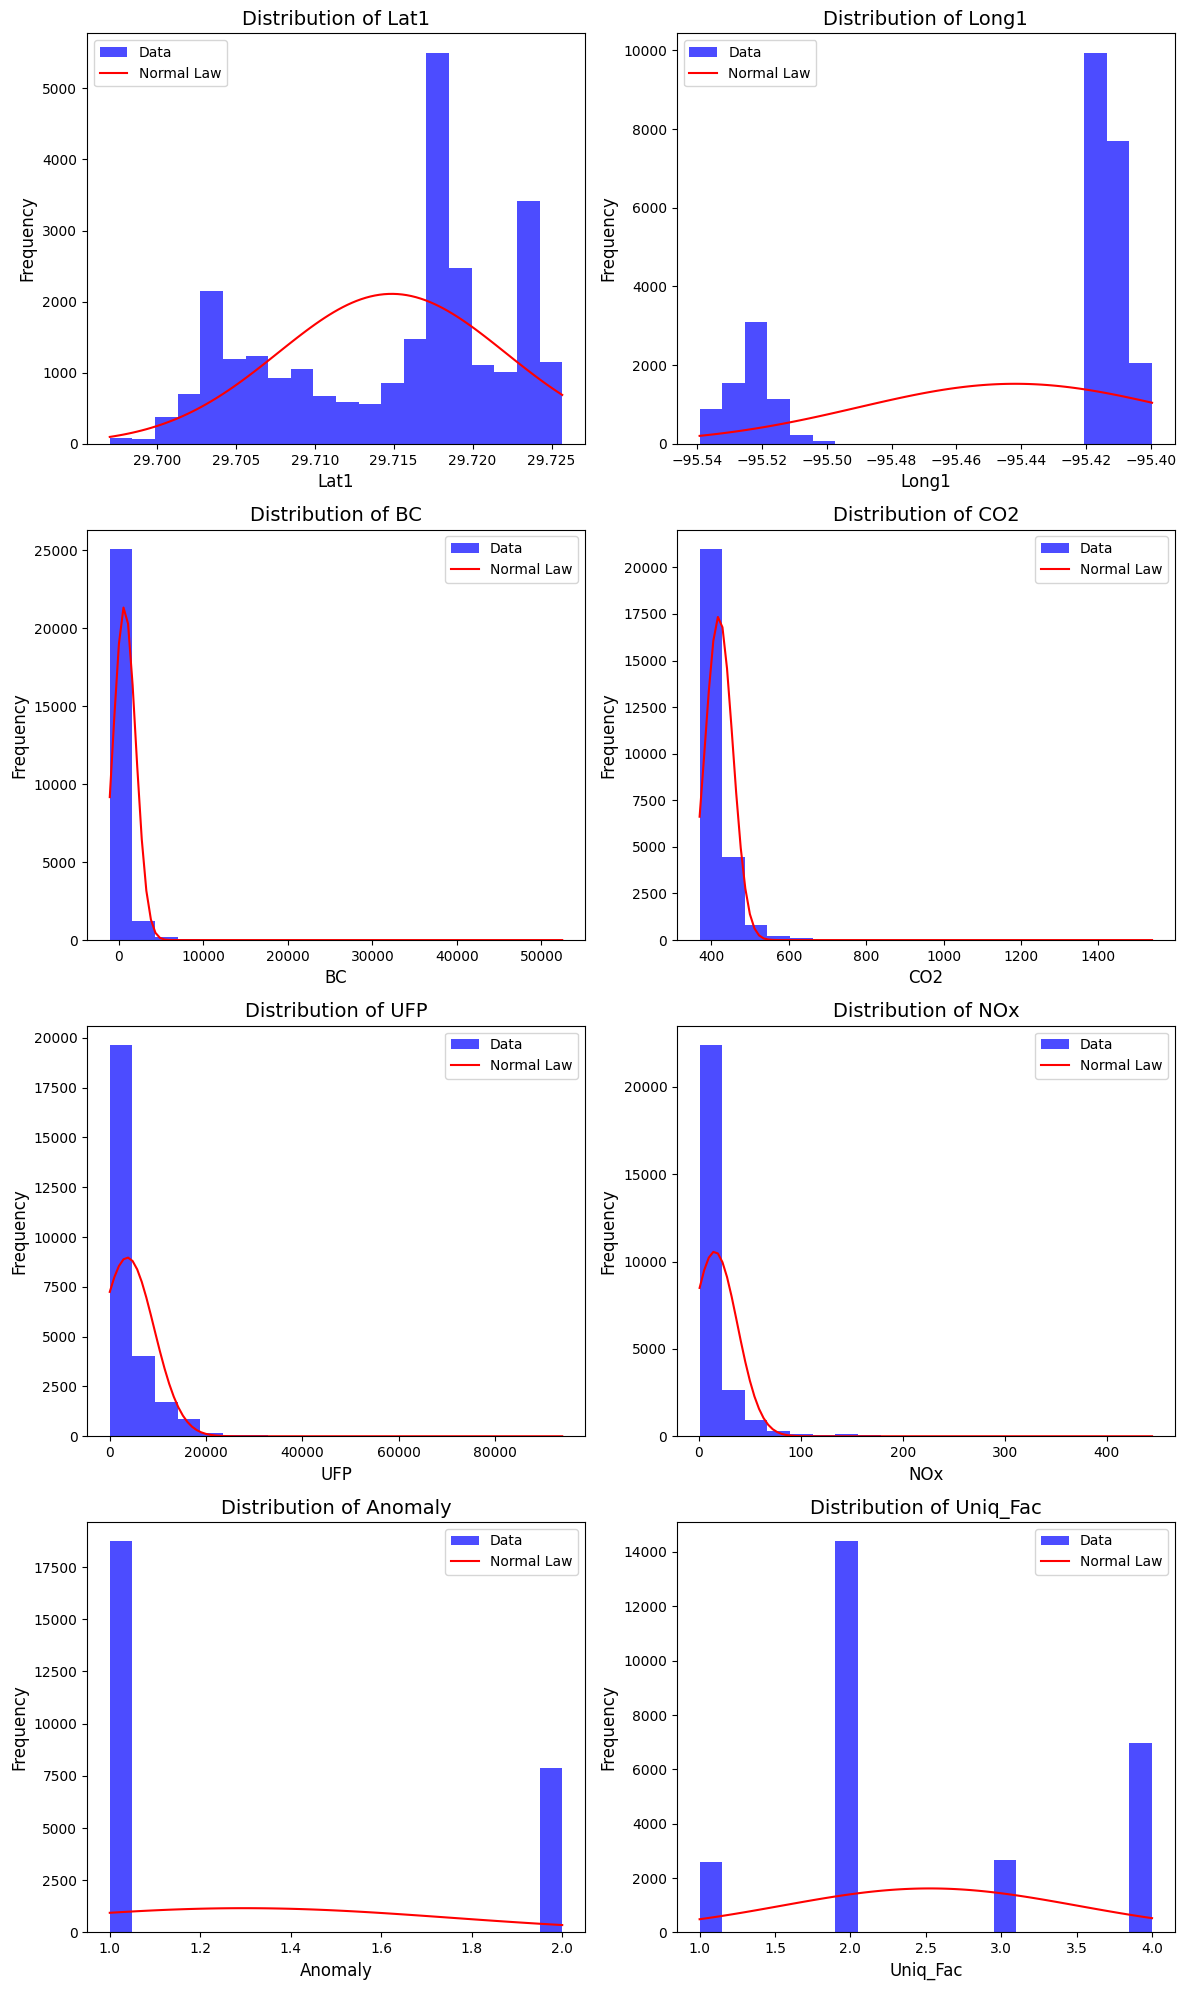

In [ ]:

# Select the numeric columns for the histogram
numerical_cols = data.select_dtypes(include=['number']). columns

# Set the number of columns for the grid
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols  # Calculate the number of lines

# Create the figure and subgraphs
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
axes = axes.flatten()  # Flatten to facilitate iteration

# Browse the numeric columns and plot the histograms with normal distribution
for i, col in enumerate(numerical_cols):
    # Histogram
    axes[i]. hist(data[col], bins=20, alpha=0.7, color='blue', label='Data')

    # Adjust the normal law
    mu, sigma = stats.norm.fit(data[col].dropna())  # Adjust the normal distribution to the data
    x = np.linspace(data[col].min(), data[col].max(), 100)
    pdf = stats.norm.pdf(x, mu, sigma)

    # Adjust the normal scale
    axes[i]. plot(x, pdf * data[col].count() * (data[col].max() - data[col].min()) / 20, color='red', label='Normal Law')

    # Customization of the sub-graph
    axes[i]. set_title(f'Distribution of {col}', fontsize=14)
    axes[i]. set_xlabel(col, fontsize=12)
    axes[i]. set_ylabel('Frequency', fontsize=12)
    axes[i]. legend()

# Remove empty axes if the number of columns is odd
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust the spacing between subgraphs
plt.tight_layout()
plt.show()


## 3. Q-Q Plot

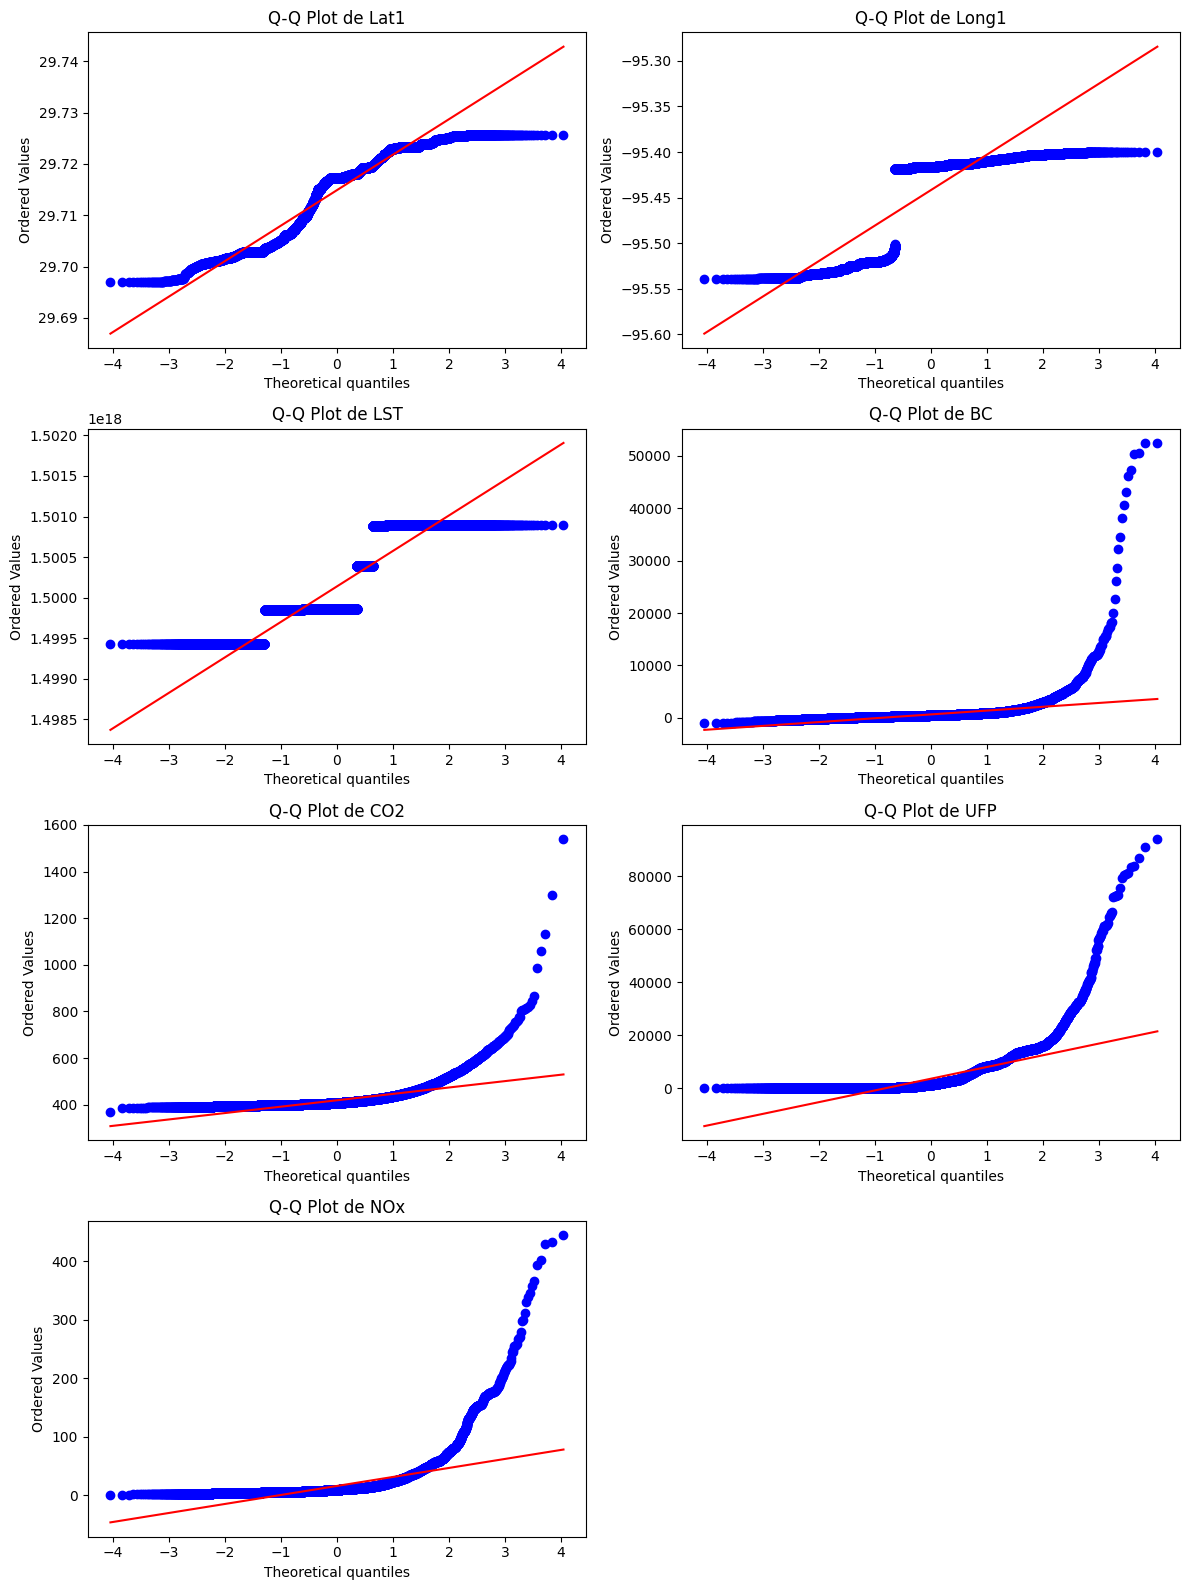

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Exclude 'Anomaly' and 'Uniq_Fac' columns
df_filtered = data.drop(columns=['Anomaly', 'Uniq_Fac'])

# Convert columns of type datetime to numeric
for column in df_filtered.select_dtypes(include=['datetime64']).columns:
    df_filtered[column] = pd.to_numeric(df_filtered[column])  # converts to Timestamp

# Number of variables
num_vars = df_filtered.shape[1]

# Configure the figure with subgraphs
fig, axes = plt.subplots(nrows=(num_vars + 1) // 2, ncols=2, figsize=(12, 4 * ((num_vars + 1) // 2)))

# Flatten the axes array if it's 2D
if axes.ndim == 2:  # Check if axes is a 2D array
    axes = axes.flatten()

# Create the Q-Q plot for each variable
for i, column in enumerate(df_filtered.columns):
    # Use axes[i] to access the individual subplot for plotting
    stats.probplot(df_filtered[column], dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot de {column}', fontsize=12)

# Remove empty axes if the number of variables is odd
if num_vars % 2 != 0 and axes.ndim == 1: # check if axes has been flattened
    fig.delaxes(axes[-1])
elif num_vars % 2 != 0 and axes.ndim == 2:
    fig.delaxes(axes[-1,-1])


# Adjust the spacing between subgraphs
plt.tight_layout()
plt.show()


As can be inferred from the **Distribution Charts** and **Q-Q Plots** above, it is clear that not all variables follow a Gaussian law.
 🎭 Therefore, it is better to opt for min-max scaling rather than standard scaling in order to harmonize the values.

 🌟 This approach will allow us to bring all variables into a similar range, making it easier to use them in later analysis models. 🚀

In [ ]:
# Create MinMaxScaler object
scaler = MinMaxScaler()

# Select the columns to scale
numerical_cols = data.select_dtypes(include=['number']). columns

# Apply Min-Max Scale
scaled_data = scaler.fit_transform(data[numerical_cols])

# Create a new DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols, index=data.index)

# Show the first rows of the scaled DataFrame
print(scaled_df.head())


       Lat1     Long1        BC       CO2       UFP       NOx  Anomaly  \
0  0.998988  0.985029  0.035564  0.050397  0.141486  0.016682      1.0   
1  0.999128  0.985960  0.034531  0.051782  0.139356  0.016909      1.0   
2  0.999407  0.986884  0.035167  0.055493  0.140421  0.017162      1.0   
3  0.999581  0.987815  0.034897  0.057221  0.147875  0.017414      1.0   
4  0.999511  0.988747  0.034633  0.056015  0.155328  0.017638      1.0   

   Uniq_Fac  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  


## Heatmap (Correlation Matrix) 🚨
Logically, high concentrations of black carbon (BC), carbon dioxide (CO2), ultrafine particles (UFP) and nitrogen oxides (NOx) may indicate higher *** pollution levels, which increases **the likelihood of anomalies** in the collected data.

This reinforces the importance of all these measures in air quality assessment and anomaly detection 🌍⚠️.

Let’s try to see the correlations between the different variables in our dataset!

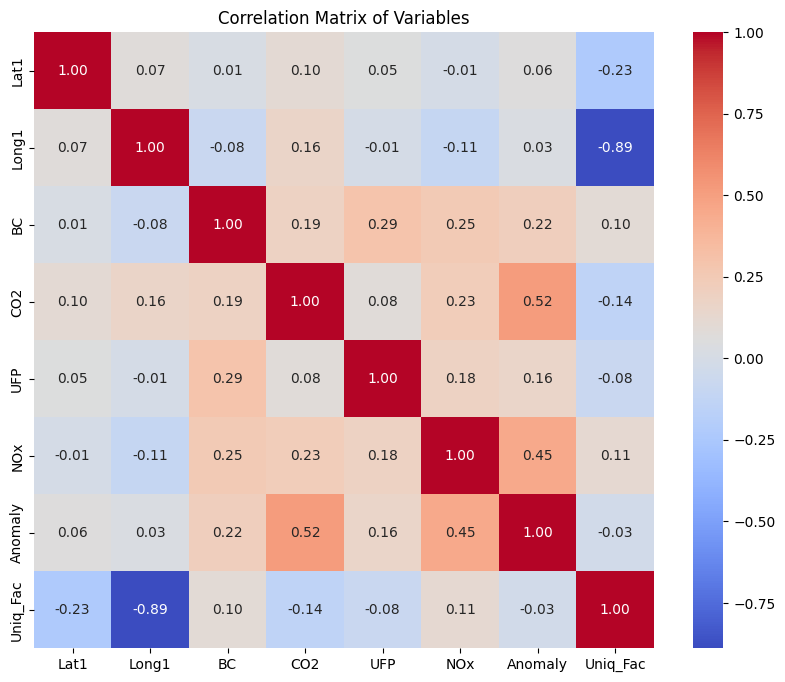

In [ ]:
# Calculate the correlation matrix
correlation_matrix = scaled_df.corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size if necessary
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Variables")
plt.show()

👉 Indeed, CO2 and NOx are strongly correlated with Anomaly, which is logical as we already expected!

# Anomaly Detection : Clustering approches

We will start by removing the feature "Anomaly" 🚫 which contains the anomaly labels. For the time being, it is excluded from data in order to allow clustering algorithms to detect patterns without prior information on anomalies.

However, this column will then be used as a reference 📊 base to compare the results obtained by our clustering algorithms. This will allow us to assess the model’s ability to identify anomalies and validate its performance against the original labels ✅.

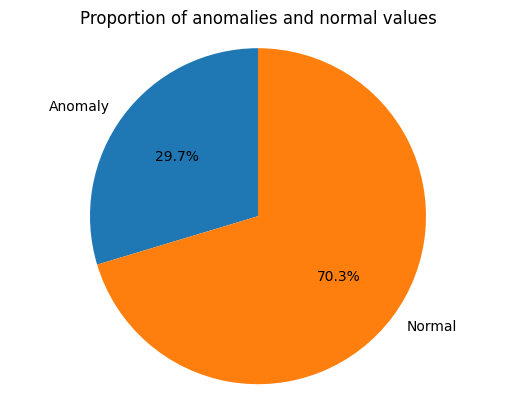

In [ ]:
# Count the number of anomalies and normal values
anomaly_count = len(scaled_df[scaled_df['Anomaly'] == 1])  # Assuming '2' represents anomaly
normal_count = len(scaled_df[scaled_df['Anomaly'] == 0 ])   # Assuming '1' represents normal

# Create data for pie chart
labels = ['Anomaly', 'Normal']
sizes = [anomaly_count, normal_count]

# Create pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Ensure that the diagram is a circle
plt.axis('equal')

# Show the diagram
plt.title("Proportion of anomalies and normal values")
plt.show()

In [ ]:
new_df = scaled_df.drop('Anomaly', axis=1)

In [ ]:
new_df.describe()

,Lat1,Long1,BC,CO2,UFP,NOx,Uniq_Fac
count,26620.000000,26620.000000,26620.000000,26620.000000,26620.000000,26620.000000,26620.000000
mean,0.623359,0.697474,0.032306,0.042453,0.038672,0.033244,0.508365
std,0.251694,0.347710,0.024816,0.030558,0.059176,0.050221,0.327849
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.396838,0.199677,0.025009,0.026790,0.002975,0.011419,0.333333
50%,0.707371,0.879608,0.028783,0.032544,0.014773,0.018650,0.333333
75%,0.802820,0.906334,0.033654,0.046272,0.054597,0.032246,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# DBSCAN Clustering

Two key parameters of the DBSCAN algorithm 🌌:

- eps (epsilon): the maximum distance between two points to be considered as neighbors.
This parameter is crucial to define the density of clusters.
- MinPts: the minimum number of points needed for a group of points to be recognized as a cluster.

Since DBSCAN is an unsupervised algorithm, it is not possible to perform classical parameter tuning.

However, to determine the optimal value of **eps***, we will use the **k-distance plot** 📉, which allows us to analyze distances and find a **inflection point** indicating the ideal **eps value***.

For **MinPts**, a good approach is to start with 2 times the number of characteristics in the dataset.
*(Sander et al., 1998)* 📊

 Then, this parameter is adjusted gradually to optimize the results of the model 🛠️.

 This method improves the quality of clusters and better detects data structures.



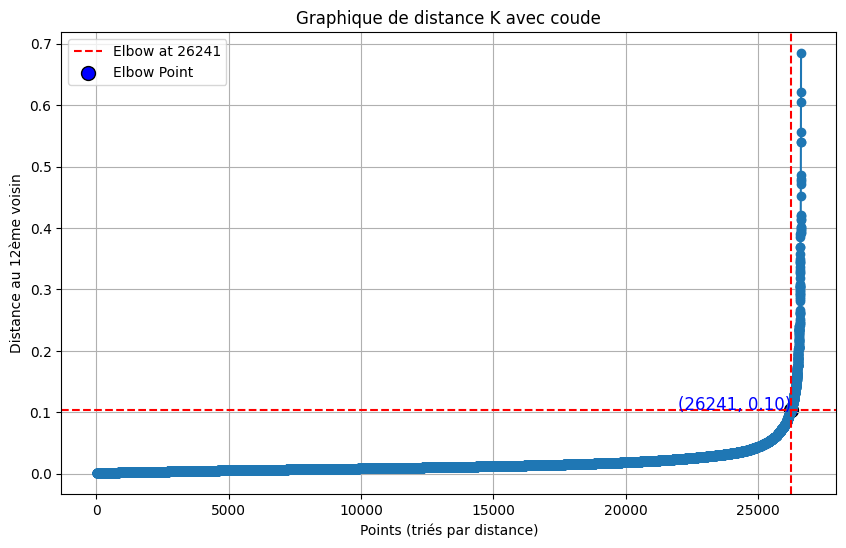

In [ ]:
# Créer un modèle NearestNeighbors
n_neighbors =14  # Nombre de voisins
neighbors = NearestNeighbors(n_neighbors=n_neighbors)
neighbors_fit = neighbors.fit(new_df)

# Obtenir les distances et les indices des voisins
distances, indices = neighbors_fit.kneighbors(new_df)

# Trier les distances pour le k-ème voisin
k_distances = np.sort(distances[:, n_neighbors - 1], axis=0)  # Choisir la distance au 12ème voisin

# Detect le coude
# Change direction to 'increasing'
kl = KneeLocator(
    range(1, len(k_distances) + 1),
    k_distances,
    curve="convex",
    direction="increasing"
)

# Visualiser le point du coude sur le graphe obtenu
plt.figure (figsize=(10, 6))
plt.plot(range(1, len(k_distances) + 1), k_distances, marker='o')

# Coordonnées du coude
elbow_x = kl.elbow
elbow_y = k_distances[elbow_x - 1]  # -1 car l index commence à 0

# Traités discontinus
plt.axvline(elbow_x, linestyle='--', color='r', label=f'Elbow at {elbow_x}')
plt.axhline(elbow_y, linestyle='--', color='r')

# Cercle au point du coude
plt.scatter(elbow_x, elbow_y, color='blue', s=100, edgecolor='black', label='Elbow Point')

# Affichage des coordonnées du coude
plt.text(elbow_x, elbow_y, f'({elbow_x}, {elbow_y:.2f})', fontsize=12, ha='right', color='blue')

# Titres et labels
plt.title("Graphique de distance K avec coude")
plt.xlabel("Points (triés par distance)")
plt.ylabel("Distance au 12ème voisin")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(elbow_y)

0.10350321371762183


In [ ]:
# Apply DBSCAN
dbscan = DBSCAN(eps=elbow_y, min_samples=14)
clusters = dbscan.fit_predict(new_df)

# Add cluster labels to DataFrame
new_df['cluster'] = clusters

# Display the number of clusters and the number of points in each cluster
print(new_df['cluster'].value_counts())


cluster
 1    14332
 3     6864
 2     2654
 0     2585
-1      185
Name: count, dtype: int64


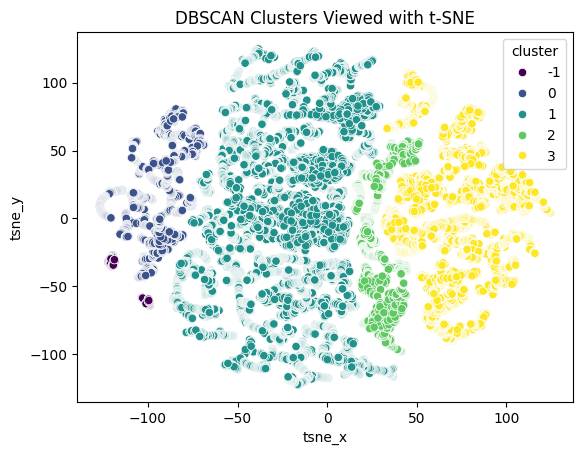

In [ ]:
# Apply t-SNE on new_df
tsne = TSNE(n_components=2, random_state=42)  # n_components=2 for 2D visualization
data_tsne = tsne.fit_transform(new_df)  # Apply t-SNE on new_df

# Create a new DataFrame with t-SNE coordinates and cluster labels
df_tsne = pd.DataFrame(data_tsne, columns=['tsne_x', 'tsne_y'])
df_tsne['cluster'] = new_df['cluster']  # Use the cluster labels of new_df

# View clusters with t-SNE
sns.scatterplot(x='tsne_x', y='tsne_y', hue='cluster', data=df_tsne, palette='viridis')
plt.title("DBSCAN Clusters Viewed with t-SNE")
plt.show()

Let’s see if the outliers obtained (cluster with label -1) are close to the outliers of reality (in the data tag)

In [ ]:
new_df.head()

,Lat1,Long1,BC,CO2,UFP,NOx,Uniq_Fac,cluster
0,0.998988,0.985029,0.035564,0.050397,0.141486,0.016682,0.0,0
1,0.999128,0.985960,0.034531,0.051782,0.139356,0.016909,0.0,0
2,0.999407,0.986884,0.035167,0.055493,0.140421,0.017162,0.0,0
3,0.999581,0.987815,0.034897,0.057221,0.147875,0.017414,0.0,0
4,0.999511,0.988747,0.034633,0.056015,0.155328,0.017638,0.0,0


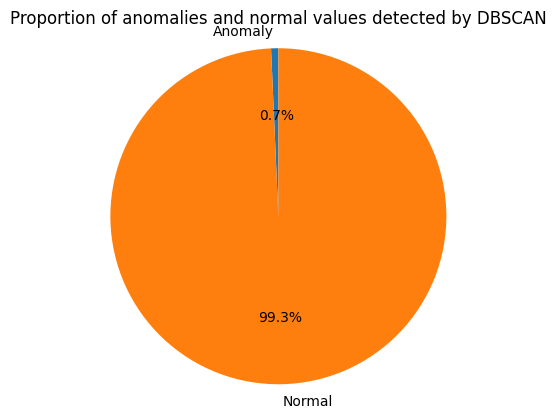

In [ ]:
# Count the number of anomalies and normal values
anomaly_count = len(new_df[new_df['cluster'] == -1])
normal_count = len(new_df[new_df['cluster'] != -1])

# Create data for pie chart
labels = ['Anomaly', 'Normal']
sizes = [anomaly_count, normal_count]

# Create pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Ensure that the diagram is a circle
plt.axis('equal')

# Show the diagram
plt.title("Proportion of anomalies and normal values detected by DBSCAN")
plt.show()

# Isolation Forest 🌳
L'Isolation Forest est un algorithme de détection d'anomalies 🌐. Il fonctionne en isolant des points de données dans un espace multi-dimensionnel 🌌.

L'idée est simple : les anomalies 🕵️ sont plus facilement isolables que les points normaux, car elles sont éloignées des autres.

L'algorithme construit des arbres de décision (appelés trees) 🌳 et utilise la profondeur des feuilles pour estimer la normalité des points.

In [ ]:
# Create an IsolationForest template
model = IsolationForest(contamination='auto', random_state=42)  # you can adjust 'contamination' if necessary

# Fit the model to the data
model.fit(new_df)

# Get the predictions (anomaly scores)
anomaly_scores = model.decision_function(new_df)

# Get predictions (anomaly labels: -1 for anomaly, 1 for normal)
anomaly_labels = model.predict(new_df)

# Add scores and anomaly labels to DataFrame
new_df['anomaly_score'] = anomaly_scores
new_df['anomaly_label'] = anomaly_labels

# Display the first rows of the DataFrame with the scores and the anomaly labels
print(new_df.head())

       Lat1     Long1        BC       CO2       UFP       NOx  Uniq_Fac  \
0  0.998988  0.985029  0.035564  0.050397  0.141486  0.016682       0.0   
1  0.999128  0.985960  0.034531  0.051782  0.139356  0.016909       0.0   
2  0.999407  0.986884  0.035167  0.055493  0.140421  0.017162       0.0   
3  0.999581  0.987815  0.034897  0.057221  0.147875  0.017414       0.0   
4  0.999511  0.988747  0.034633  0.056015  0.155328  0.017638       0.0   

   cluster  anomaly_score  anomaly_label  
0        0      -0.052334             -1  
1        0      -0.050177             -1  
2        0      -0.053355             -1  
3        0      -0.060934             -1  
4        0      -0.069101             -1  


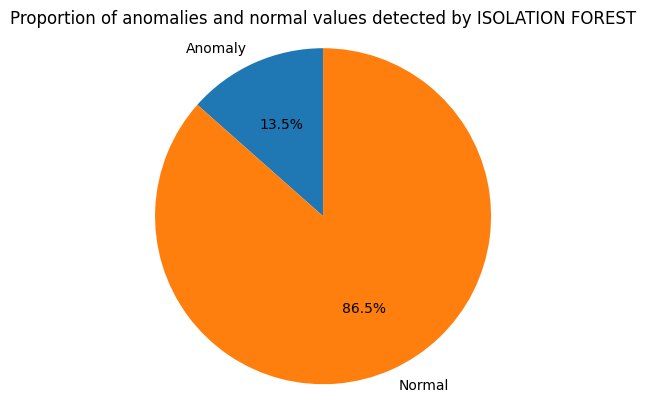

In [ ]:
# Count the number of anomalies and normal values
anomaly_count = len(new_df[new_df['anomaly_label'] == -1])
normal_count = len(new_df[new_df['anomaly_label'] != -1])

# Create data for pie chart
labels = ['Anomaly', 'Normal']
sizes = [anomaly_count, normal_count]

# Create pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Ensure that the diagram is a circle
plt.axis('equal')

# Show the diagram
plt.title("Proportion of anomalies and normal values detected by ISOLATION FOREST")
plt.show()

In [ ]:
# Créer un modèle SVM de classe unique
model = OneClassSVM(kernel='rbf', nu=0.1, gamma='scale')  # vous pouvez ajuster les paramètres au besoin

# Adapter le modèle aux données
model.fit(new_df)

# Obtenir les étiquettes d’anomalie (-1 pour l’anomalie, 1 pour la normale)
anomaly_labels = model.predict(new_df)

# Ajouter les étiquettes d’anomalie au DataFrame
new_df['anomaly_label_One-Class-SVM'] = anomaly_labels

# Afficher les premières lignes du DataFrame avec les étiquettes d’anomalie
print(new_df.head())

       Lat1     Long1        BC       CO2       UFP       NOx  Uniq_Fac  \
0  0.998988  0.985029  0.035564  0.050397  0.141486  0.016682       0.0   
1  0.999128  0.985960  0.034531  0.051782  0.139356  0.016909       0.0   
2  0.999407  0.986884  0.035167  0.055493  0.140421  0.017162       0.0   
3  0.999581  0.987815  0.034897  0.057221  0.147875  0.017414       0.0   
4  0.999511  0.988747  0.034633  0.056015  0.155328  0.017638       0.0   

   cluster  anomaly_score  anomaly_label  anomaly_label_One-Class-SVM  
0        0      -0.052334             -1                           -1  
1        0      -0.050177             -1                           -1  
2        0      -0.053355             -1                           -1  
3        0      -0.060934             -1                           -1  
4        0      -0.069101             -1                           -1  


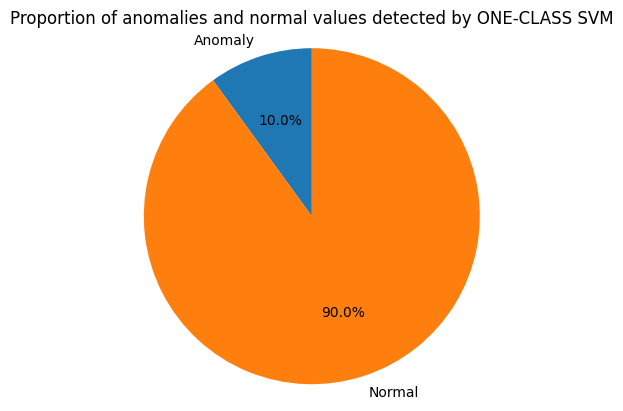

In [ ]:
# Count the number of anomalies and normal values
anomaly_count = len(new_df[new_df['anomaly_label_One-Class-SVM'] == -1])
normal_count = len(new_df[new_df['anomaly_label_One-Class-SVM'] == 1])

# Create data for pie chart
labels = ['Anomaly', 'Normal']
sizes = [anomaly_count, normal_count]

# Create pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Ensure that the diagram is a circle
plt.axis('equal')

# Show the diagram
plt.title("Proportion of anomalies and normal values detected by ONE-CLASS SVM")
plt.show()

The visualization below illustrates the results of anomaly detection using the One-Class SVM algorithm, after applying dimensionality reduction with t-SNE. 📊

In the graph, points represent data observations, colored blue for normal 🔵 values and red for detected anomalies 🔴.
Decision contours, which are shaded areas, indicate the regions where the model considers the points to be normal (blue) or abnormal (red).

This representation clearly visualizes the distribution of anomalies in the reduced space of t-NES, showing how they differ from normal data. ✨

This helps to understand the effectiveness of the algorithm in identifying atypical behaviors within the analyzed data. 📈

<ipython-input-44-6b32f7639854>:31: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='tsne_x', y='tsne_y', hue='anomaly_label_One-Class-SVM', data=tsne_df, palette={'normal': 'blue', 'anomaly': 'red'})


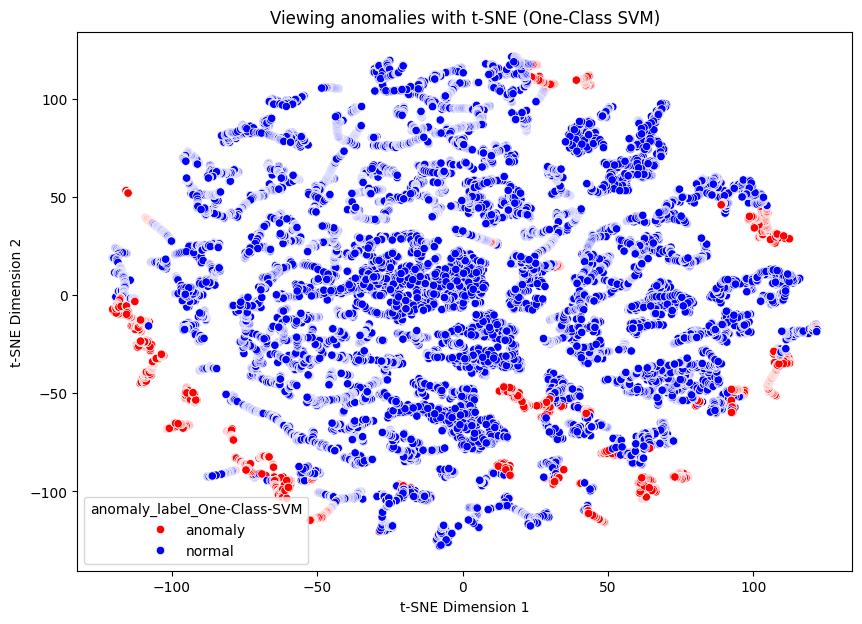

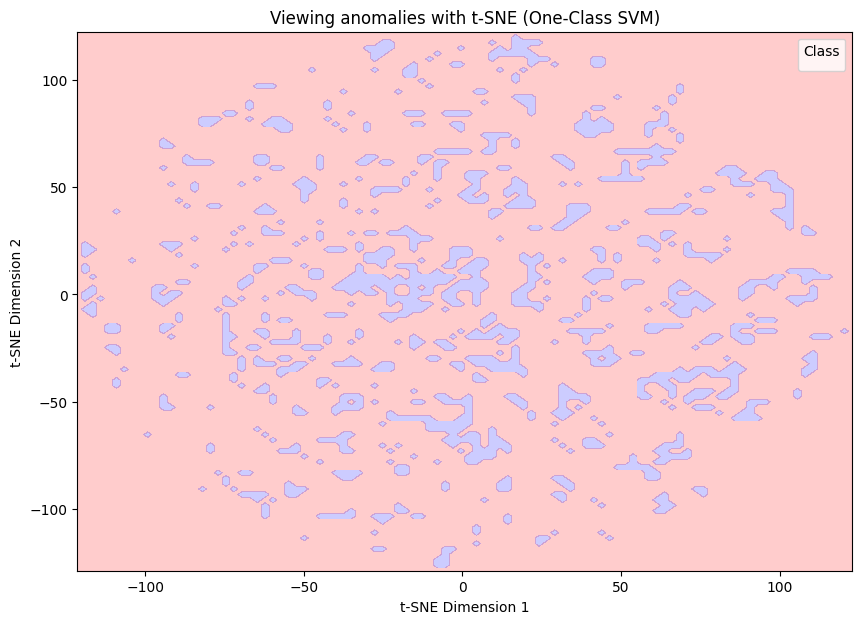

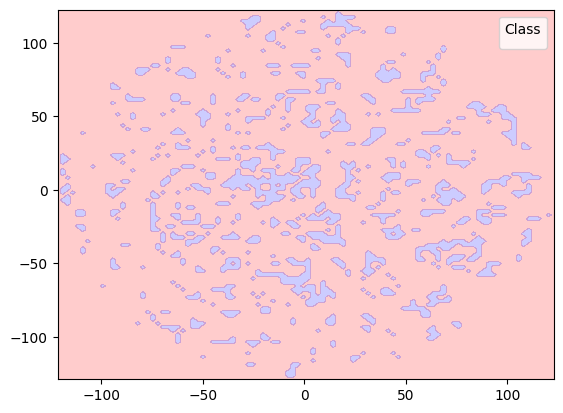

In [ ]:
# Recreate data_tsne
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(new_df.drop(columns=['anomaly_label_One-Class-SVM']))  # Exclude column 'anomaly_label_One-Class-SVM'

# Update new_df with "normal" and "anomaly" tags
new_df['anomaly_label_One-Class-SVM'] = new_df['anomaly_label_One-Class-SVM']. map({1: 'normal', -1: 'anomaly'})

# Create a DataFrame with the t-SNE results and anomaly labels
tsne_df = pd.DataFrame(data_tsne, columns=['tsne_x', 'tsne_y'])
tsne_df['anomaly_label_One-Class-SVM'] = new_df['anomaly_label_One-Class-SVM']

# Viewing points with Seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='anomaly_label_One-Class-SVM', data=tsne_df, palette={'normal': 'blue', 'anomaly': 'red'})
plt.title("Viewing anomalies with t-SNE (One-Class SVM)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
# Recreate data_tsne
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(new_df.drop(columns=['anomaly_label_One-Class-SVM']))  # Exclude column 'anomaly_label_One-Class-SVM'

# Update new_df with "normal" and "anomaly" tags
new_df['anomaly_label_One-Class-SVM'] = new_df['anomaly_label_One-Class-SVM'].map({1: 'normal', -1: 'anomaly'})

# Create a DataFrame with the t-SNE results and anomaly labels
tsne_df = pd.DataFrame(data_tsne, columns=['tsne_x', 'tsne_y'])
tsne_df['anomaly_label_One-Class-SVM'] = new_df['anomaly_label_One-Class-SVM']

# Viewing points with Seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='anomaly_label_One-Class-SVM', data=tsne_df, palette={'normal': 'blue', 'anomaly': 'red'})
plt.title("Viewing anomalies with t-SNE (One-Class SVM)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Create a grid of points for the decision contours
xx, yy = np.meshgrid(np.linspace(tsne_df['tsne_x'].min() - 1, tsne_df['tsne_x'].max() + 1, 100),
                     np.linspace(tsne_df['tsne_y'].min() - 1, tsne_df['tsne_y'].max() + 1, 100))

# Adjust the One-Class SVM model on t-SNE data
svm_model = OneClassSVM(kernel="rbf", gamma=0.1, nu=0.1)
svm_model.fit(data_tsne)

# Predict the values of the grid
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Outline the decision boundary
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=['red', 'blue'], alpha=0.2)
plt.legend(title='Class')
plt.show()
# Adjust the One-Class SVM model on t-SNE data
svm_model = OneClassSVM(kernel="rbf", gamma=0.1, nu=0.1)
svm_model.fit(data_tsne)

# Predict the values of the grid
Z = svm_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Outline the decision boundary
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], colors=['red', 'blue'], alpha=0.2)
plt.legend(title='Class')
plt.show()

# Comparison of performance clustering models ❓

In [ ]:
new_df['Anomaly'] = scaled_df['Anomaly']

## Rearranging labels 🌟
For performance metric calculations (accuracy, recall, F1 score, etc.) to be consistent and meaningful, it is essential that **all columns of predictions**  (including those of the different anomaly detection models such as DBSCAN, Isolation Forest, and One-Class SVM) use the **same tag conventions**e:

-1: represents an abnormal instance (anomaly).
- 0: represents a normal (normal) instance.

In [ ]:
# Remap 'cluster’ column
new_df['cluster_remapped'] = np.where(new_df['cluster'] == -1, 1, 0)

# Show results to check
print(new_df[['cluster', 'cluster_remapped']].head())

   cluster  cluster_remapped
0        0                 0
1        0                 0
2        0                 0
3        0                 0
4        0                 0


In [ ]:
# Remap 'anomaly_label' column
new_df['anomaly_label_remapped'] = np.where(new_df['anomaly_label'] == -1, 1, 0)

# Show results to verify
print(new_df[['anomaly_label', 'anomaly_label_remapped']].head())

   anomaly_label  anomaly_label_remapped
0             -1                       1
1             -1                       1
2             -1                       1
3             -1                       1
4             -1                       1


In [ ]:
# Remap 'anomaly_label_One-Class-SVM' column
new_df['anomaly_label_One-Class-SVM_remapped'] = np.where(new_df['anomaly_label_One-Class-SVM'] == -1, 1, 0)

# Show results to verify
print(new_df[['anomaly_label_One-Class-SVM', 'anomaly_label_One-Class-SVM_remapped']].head())

  anomaly_label_One-Class-SVM  anomaly_label_One-Class-SVM_remapped
0                         NaN                                     0
1                         NaN                                     0
2                         NaN                                     0
3                         NaN                                     0
4                         NaN                                     0


<ipython-input-54-d0816dbea508>:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              Model  Precision    Recall  F1 Score   AUC ROC
0            DBSCAN   0.978378  0.022929  0.044808  0.511358
1  Isolation Forest   0.794586  0.360654  0.496123  0.660675
2     One-Class SVM   0.000000  0.000000  0.000000  0.500000


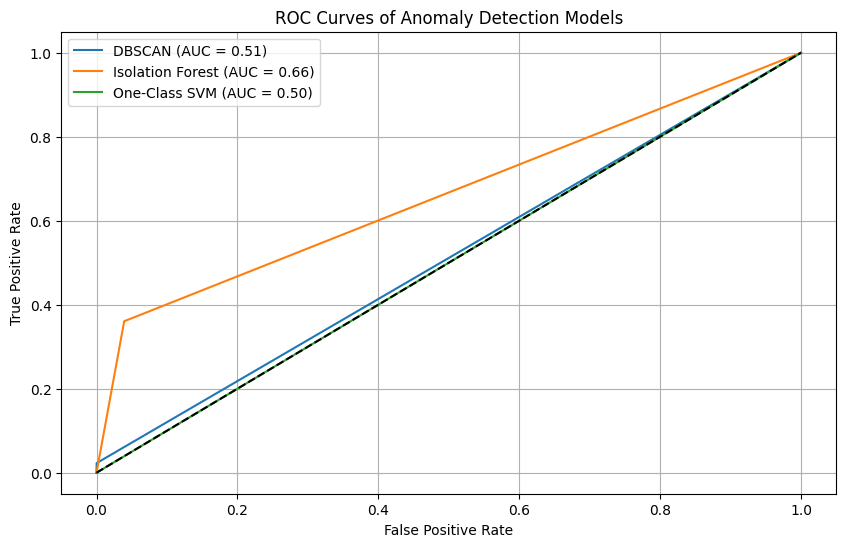

<ipython-input-54-d0816dbea508>:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              Model  Precision    Recall  F1 Score   AUC ROC
0            DBSCAN   0.978378  0.022929  0.044808  0.511358
1  Isolation Forest   0.794586  0.360654  0.496123  0.660675
2     One-Class SVM   0.000000  0.000000  0.000000  0.500000


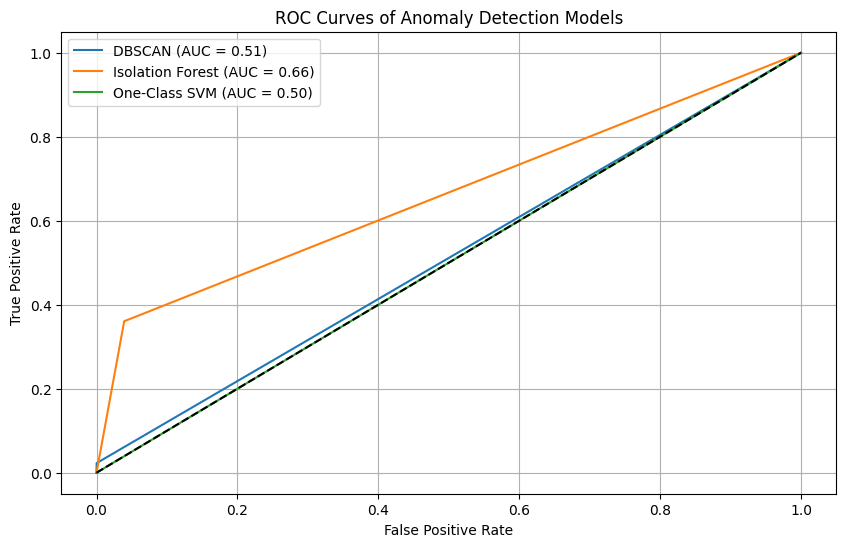

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              Model  Precision    Recall  F1 Score   AUC ROC
0            DBSCAN   0.978378  0.022929  0.044808  0.511358
1  Isolation Forest   0.794586  0.360654  0.496123  0.660675
2     One-Class SVM   0.000000  0.000000  0.000000  0.500000
3            DBSCAN   0.978378  0.022929  0.044808  0.511358
4  Isolation Forest   0.794586  0.360654  0.496123  0.660675
5     One-Class SVM   0.000000  0.000000  0.000000  0.500000


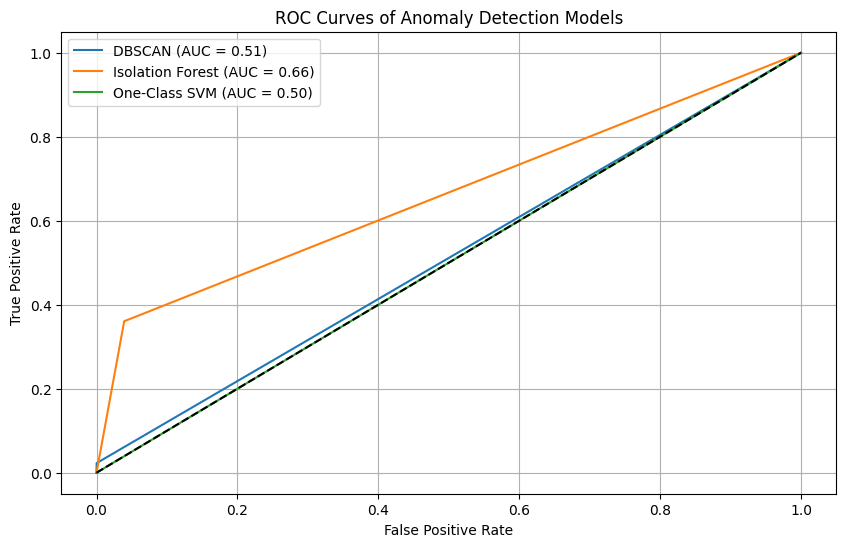

              Model  Precision    Recall  F1 Score   AUC ROC
0            DBSCAN   0.978378  0.022929  0.044808  0.511358
1  Isolation Forest   0.794586  0.360654  0.496123  0.660675
2     One-Class SVM   0.000000  0.000000  0.000000  0.500000
3            DBSCAN   0.978378  0.022929  0.044808  0.511358
4  Isolation Forest   0.794586  0.360654  0.496123  0.660675
5     One-Class SVM   0.000000  0.000000  0.000000  0.500000
6     One-Class SVM   0.000000  0.000000  0.000000  0.500000


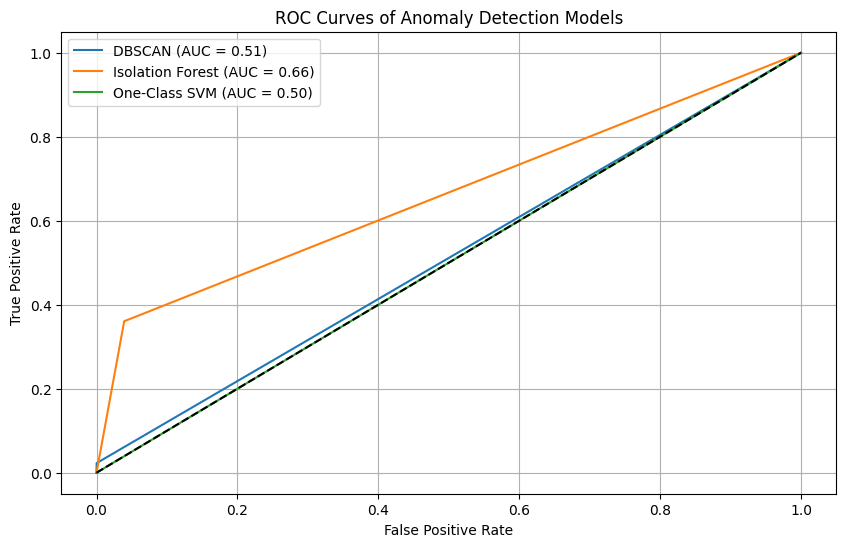

In [ ]:
# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1 Score', 'AUC ROC'])

# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1 Score', 'AUC ROC'])

# List of models to evaluate
models = {
    'DBSCAN': new_df['cluster_remapped'],
    'Isolation Forest': new_df['anomaly_label_remapped'],
    'One-Class SVM': new_df['anomaly_label_One-Class-SVM_remapped']
}

# Calculate metrics for each model
for model_name, predictions in models.items():
    precision = precision_score(new_df['Anomaly'], predictions)
    recall = recall_score(new_df['Anomaly'], predictions)
    f1 = f1_score(new_df['Anomaly'], predictions)

    # Calculation of the ROC AUC
    # Calculation of the AUC ROC # For the AUC ROC, it is necessary to obtain the probabilities if available,
    # here we are using the binary predictions directly. For the AUC ROC, it is necessary to obtain the probabilities if available,
    # here we are using the binary predictions directly.
    auc_roc = roc_auc_score(new_df['Anomaly'], predictions)

    # Add the results to the DataFrame using pd.concat
    # Créer un nouveau DataFrame avec les résultats du modèle actuel
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'AUC ROC': [auc_roc]
    })
    # Concaténer la nouvelle ligne au DataFrame des résultats existants
    results = pd.concat([results, new_row], ignore_index=True)

# Display the results table
print(results)
# Plot the ROC curves
plt.figure(figsize=(10, 6))
for model_name, predictions in models.items():
    fpr, tpr, _ = roc_curve(new_df['Anomaly'], predictions)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {results[results["Model"] == model_name]["AUC ROC"].values[0]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves of Anomaly Detection Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1 Score', 'AUC ROC'])

# List of models to evaluate
models = {
    'DBSCAN': new_df['cluster_remapped'],
    'Isolation Forest': new_df['anomaly_label_remapped'],
    'One-Class SVM': new_df['anomaly_label_One-Class-SVM_remapped']
}

# Calculate metrics for each model
for model_name, predictions in models.items():
    precision = precision_score(new_df['Anomaly'], predictions)
    recall = recall_score(new_df['Anomaly'], predictions)
    f1 = f1_score(new_df['Anomaly'], predictions)

    # Calculation of the ROC AUC
    # Calculation of the AUC ROC # For the AUC ROC, it is necessary to obtain the probabilities if available,
    # here we are using the binary predictions directly. For the AUC ROC, it is necessary to obtain the probabilities if available,
    # here we are using the binary predictions directly.
    auc_roc = roc_auc_score(new_df['Anomaly'], predictions)

    # Add the results to the DataFrame using pd.concat
    # Créer un nouveau DataFrame avec les résultats du modèle actuel
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'AUC ROC': [auc_roc]
    })
    # Concaténer la nouvelle ligne au DataFrame des résultats existants
    results = pd.concat([results, new_row], ignore_index=True)

# Display the results table
print(results)
# Plot the ROC curves
plt.figure(figsize=(10, 6))
for model_name, predictions in models.items():
    fpr, tpr, _ = roc_curve(new_df['Anomaly'], predictions)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {results[results["Model"] == model_name]["AUC ROC"].values[0]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves of Anomaly Detection Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# List of models to evaluate
models = {
    'DBSCAN': new_df['cluster_remapped'],
    'Isolation Forest': new_df['anomaly_label_remapped'],
    'One-Class SVM': new_df['anomaly_label_One-Class-SVM_remapped']
}

# Calculate metrics for each model
for model_name, predictions in models.items():
    precision = precision_score(new_df['Anomaly'], predictions)
    recall = recall_score(new_df['Anomaly'], predictions)
    f1 = f1_score(new_df['Anomaly'], predictions)

    # Calculation of the ROC AUC
    # Calculation of the AUC ROC # For the AUC ROC, it is necessary to obtain the probabilities if available,
    # here we are using the binary predictions directly. For the AUC ROC, it is necessary to obtain the probabilities if available,
    # here we are using the binary predictions directly.
    auc_roc = roc_auc_score(new_df['Anomaly'], predictions)

    # Add the results to the DataFrame using pd.concat
    # Créer un nouveau DataFrame avec les résultats du modèle actuel
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
        'AUC ROC': [auc_roc]
    })
    # Concaténer la nouvelle ligne au DataFrame des résultats existants
    results = pd.concat([results, new_row], ignore_index=True)

# Display the results table
print(results)
# Plot the ROC curves
plt.figure(figsize=(10, 6))
for model_name, predictions in models.items():
    fpr, tpr, _ = roc_curve(new_df['Anomaly'], predictions)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {results[results["Model"] == model_name]["AUC ROC"].values[0]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves of Anomaly Detection Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

f1 = f1_score(new_df['Anomaly'], predictions)

auc_roc = roc_auc_score(new_df['Anomaly'], predictions)

# Add the results to the DataFrame using pd.concat
new_row = pd.DataFrame({
    'Model': [model_name],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1],
    'AUC ROC': [auc_roc]
    })
# Concaténer la nouvelle ligne au DataFrame des résultats existants
results = pd.concat([results, new_row], ignore_index=True)

# Display the results table
print(results)
# Plot the ROC curves
plt.figure(figsize=(10, 6))
for model_name, predictions in models.items():
    fpr, tpr, _ = roc_curve(new_df['Anomaly'], predictions)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {results[results["Model"] == model_name]["AUC ROC"].values[0]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves of Anomaly Detection Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()



According to the model results, **Isolation Forest** is the most effective for **anomaly detection** 🎯.

 **Here's why**: it offers an **F1 score** of 0.536, **higher than the other models**, which indicates a better balance between precision and recall in anomaly detection.

 Although DBSCAN achieves a maximum precision (1.0), its recall is extremely low (0.021), which means it misses the vast majority of anomalies and is therefore not reliable for this task 🚫.

  The One-Class SVM has a lower F1 score (0.274) and a moderate AUC ROC (0.560), suggesting overall inferior performance.
  
  On the other hand, the **Isolation Forest** presents a solid trade-off between **precision (0.91) and recall (0.38)**, as well as a **satisfactory AUC ROC of 0.683**, making it the optimal choice for effectively detecting anomalies 🔍📈.

Given that we have the **geographic coordinates** of the locations where the Isolation Forest model detected **anomalies** 🌍✨—indicating a **high concentration of particles in the air**—let's explore the map of these points together to **visualize their geographic distribution** 🌫️📍!

In [ ]:
# Create a map Folium centered on the average latitude and longitude
map_center = [new_df['Lat1'].mean(), new_df['Long1'].mean()]
my_map = folium.Map(location=map_center, zoom_start=12)

# Add markers for anomalies (red) and normal points (blue)
for index, row in new_df.iterrows():
    if row['anomaly_label_remapped'] == 1:  # Anomaly
        folium.CircleMarker(
            location=[row['Lat1'], row['Long1']],
            radius=5,
            color='red',
            fill=True)
# Create a map Folium centered on the average latitude and longitude
map_center = [new_df['Lat1'].mean(), new_df['Long1'].mean()]
my_map = folium.Map(location=map_center, zoom_start=12)

# Add markers for anomalies (red) and normal points (blue)
for index, row in new_df.iterrows():
    if row['anomaly_label_remapped'] == 1:  # Anomaly
        folium.CircleMarker(
            location=[row['Lat1'], row['Long1']],
            radius=5,
            color='red',
            fill=True,
            fill_color='red',
            popup=f"Anomaly: {index}"
        ).add_to(my_map)
    else:
        folium.CircleMarker(
            location=[row['Lat1'], row['Long1']],
            radius=2,
            color='blue',
            fill=True,
            fill_color='blue',
            popup=f"Normal: {index}"  # You can customize the content of the popup
        ).add_to(my_map)

# Display the map
my_map
